<a href="https://colab.research.google.com/github/LSE-60420-2526/GY476-2025-SUMMATIVE-ASSESSMENT/blob/main/GroupX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nash Equilibrium: [1.e-323 1.e-323]

Running Q-learning simulation...


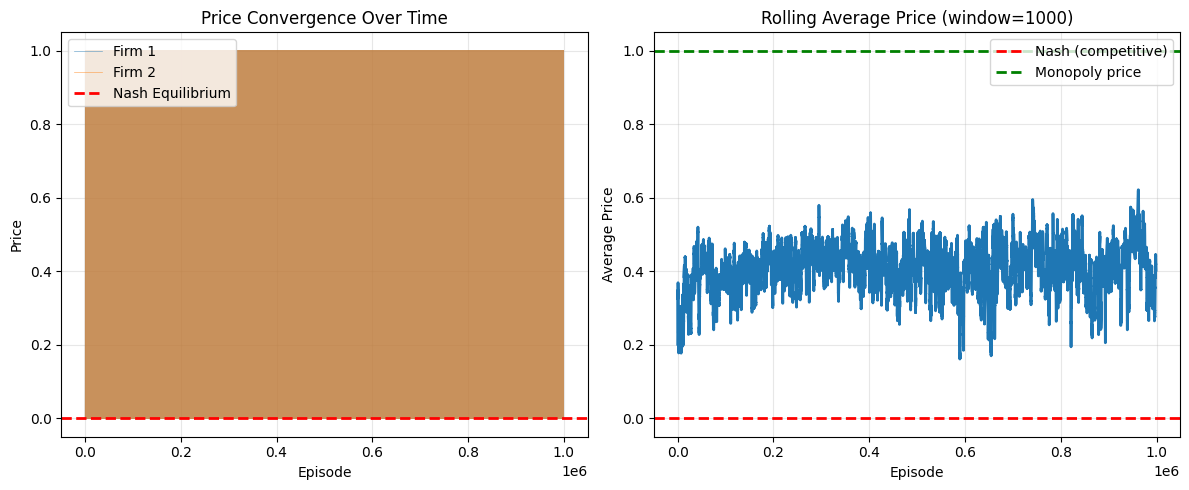


=== RESULTS ===
Final average price: 0.354
Nash equilibrium: 0.000
Monopoly price: ~1.000
Collusion level: 35.4%


In [2]:
from numpy import arange, array
from scipy import optimize
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# assume that consumer buys either one or none.
# n is the type of consumer willingness to pay
def u(p, n):
    return n - p

consumer_types = arange(0.0, 1.01, 0.01)  # 101 consumers with n varying between 0 and 1

def buy(p, n):
    if u(p, n) >= 0:
        buy = 1.0
    else:
        buy = 0.0
    return buy

# the total demand equals the sum of demands for consumers n for all consumers
def total_demand(p):
    demand_vector = [buy(p, n)/len(consumer_types) for n in consumer_types]
    return sum(demand_vector)

# we consider a duopoly with two firms. consumers will buy
# from the cheapest or pick randomly if the same price.
def profit(p1, p2, c1):
    if p1 > p2:
        profits = 0
    elif p1 == p2:
        profits = 0.5 * total_demand(p1) * (p1 - c1)
    else:
        profits = total_demand(p1) * (p1 - c1)
    return profits

def reaction(p2, c1):
    if p2 > c1:
        reaction = c1 + 0.8 * (p2 - c1)
    else:
        reaction = c1
    return reaction

def vector_reaction(p, param):
    return array(p) - array([reaction(p[1], param[0]), reaction(p[0], param[1])])

param = [0.0, 0.0]
p0 = [0.5, 0.5]
ans = optimize.fsolve(vector_reaction, p0, args=(param,))
print("Nash Equilibrium:", ans)

def collusion_profits(p, c, delta):
    # Profit from colluding at price p
    collude_profit = profit(p, p, c)
    # Nash equilibrium (punishment)
    nash_prices = optimize.fsolve(vector_reaction, [0.5, 0.5], args=([c, c],))
    nash_profit = profit(nash_prices[0], nash_prices[1], c)
    # Deviation profit (undercut slightly to steal all customers)
    deviation_price = p - 0.01  # slightly undercut collusive price
    deviation_profit = profit(deviation_price, p, c)
    # Present value of collusion forever
    PV_collusion = collude_profit / (1 - delta)
    # Present value of deviating once then getting Nash forever
    PV_deviation = deviation_profit + (delta / (1 - delta)) * nash_profit
    # Check if collusion is sustainable
    if PV_collusion >= PV_deviation:
        industry_profit = 2 * collude_profit
    else:
        industry_profit = 0
    return industry_profit
#everything before this has set up rules of the game: Set up market (consumers, demand, profit function)
"""
##
What Each Component Does:
consumer_types, u(), buy()
 - Models how customers decide to buy
total_demand()
 -Calculates how many buy at each price
profit()
 - Calculates firm profits (winner-takes-all logic)
Nash equilibrium calculation
 - Shows competitive baseline (£0)
Q-tables (Q1, Q2)
 - Agents' "memory" of what works
q_learning_simulation()
- The learning process (50,000 episodes)
price_history
 - Record of how prices evolved
Final result (£0.39)
- Evidence of learned collusion

"""
# Q-learning setup
prices = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
alpha = 0.15 #learning rate
gamma = 0.95
epsilon = 0.10 #explore rate

# Initialize Q-tables
Q1 = {}
Q2 = {}
for my_price in prices:
    for opponent_price in prices:
        Q1[(my_price, opponent_price)] = 0.0
        Q2[(opponent_price, my_price)] = 0.0
#this section below firm 1 chooses price(based on past experience), calculate firm 1 profit
#updat firm 1's memory. then is repeated independly for firm 2. with prices recorded
def q_learning_simulation(num_episodes=1000000):
    """Run Q-learning baseline simulation"""
    # Start at random prices
    p1 = random.choice(prices)
    p2 = random.choice(prices)

    price_history = []

    for episode in range(num_episodes):
        # FIRM 1's turn
        if random.random() < epsilon:
            new_p1 = random.choice(prices)
        else:
            new_p1 = max(prices, key=lambda p: Q1.get((p, p2), 0.0))

        reward1 = profit(new_p1, p2, c1=0.0)
        old_q = Q1.get((p1, p2), 0.0)
        max_future_q = max([Q1.get((new_p1, p), 0.0) for p in prices])
        Q1[(p1, p2)] = old_q + alpha * (reward1 + gamma * max_future_q - old_q)
        p1 = new_p1

        # FIRM 2's turn
        if random.random() < epsilon:
            new_p2 = random.choice(prices)
        else:
            new_p2 = max(prices, key=lambda p: Q2.get((p1, p), 0.0))

        reward2 = profit(new_p2, p1, c1=0.0)
        old_q2 = Q2.get((p1, p2), 0.0)
        max_future_q2 = max([Q2.get((p1, new_p2), 0.0) for p in prices])
        Q2[(p1, p2)] = old_q2 + alpha * (reward2 + gamma * max_future_q2 - old_q2)
        p2 = new_p2

        price_history.append([p1, p2])

    return price_history

#it learns that high mutual price = good profits, with price converging to £0.39
    # Run the simulation
print("\nRunning Q-learning simulation...")
price_history = q_learning_simulation(num_episodes=1000000)

# Convert to numpy array
prices_array = np.array(price_history)

# Plot results
plt.figure(figsize=(12, 5))

# Plot 1: Price trajectories
plt.subplot(1, 2, 1)
plt.plot(prices_array[:, 0], label='Firm 1', alpha=0.6, linewidth=0.5)
plt.plot(prices_array[:, 1], label='Firm 2', alpha=0.6, linewidth=0.5)
plt.axhline(y=0.0, color='r', linestyle='--', label='Nash Equilibrium', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Price')
plt.title('Price Convergence Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Rolling average
plt.subplot(1, 2, 2)
window = 1000
avg_prices = np.mean(prices_array, axis=1)
rolling_avg = np.convolve(avg_prices, np.ones(window)/window, mode='valid')
plt.plot(rolling_avg, linewidth=2)
plt.axhline(y=0.0, color='r', linestyle='--', label='Nash (competitive)', linewidth=2)
plt.axhline(y=1.0, color='g', linestyle='--', label='Monopoly price', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Average Price')
plt.title('Rolling Average Price (window=1000)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate final metrics
final_prices = prices_array[-10000:]  # Last 10k episodes
final_avg = np.mean(final_prices)
print(f"\n=== RESULTS ===")
print(f"Final average price: {final_avg:.3f}")
print(f"Nash equilibrium: 0.000")
print(f"Monopoly price: ~1.000")
print(f"Collusion level: {(final_avg/1.0)*100:.1f}%")


=== Testing alpha = 0.05 ===
  Trial 1: £0.136 (13.6% collusion)
  Trial 2: £0.201 (20.1% collusion)
  Trial 3: £0.362 (36.2% collusion)
  Trial 4: £0.423 (42.3% collusion)
  Trial 5: £0.286 (28.6% collusion)
  → Average: £0.281 (±0.104)

=== Testing alpha = 0.15 ===
  Trial 1: £0.335 (33.5% collusion)
  Trial 2: £0.396 (39.6% collusion)
  Trial 3: £0.337 (33.7% collusion)
  Trial 4: £0.260 (26.0% collusion)
  Trial 5: £0.378 (37.8% collusion)
  → Average: £0.341 (±0.047)

=== Testing alpha = 0.5 ===
  Trial 1: £0.445 (44.5% collusion)
  Trial 2: £0.458 (45.8% collusion)
  Trial 3: £0.402 (40.2% collusion)
  Trial 4: £0.411 (41.1% collusion)
  Trial 5: £0.456 (45.6% collusion)
  → Average: £0.434 (±0.023)

=== Testing alpha = 0.9 ===
  Trial 1: £0.490 (49.0% collusion)
  Trial 2: £0.411 (41.1% collusion)
  Trial 3: £0.478 (47.8% collusion)
  Trial 4: £0.412 (41.2% collusion)
  Trial 5: £0.437 (43.7% collusion)
  → Average: £0.446 (±0.033)


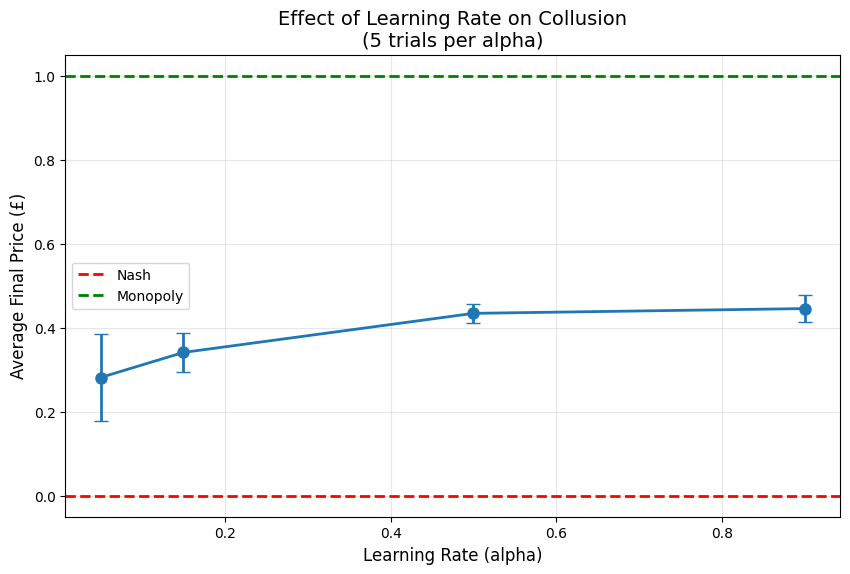

In [3]:
from numpy import arange, array
from scipy import optimize
import random
import numpy as np
import matplotlib.pyplot as plt

# Your existing setup code (u, buy, total_demand, profit functions)
def u(p, n):
    return n - p

consumer_types = arange(0.0, 1.01, 0.01)

def buy(p, n):
    if u(p, n) >= 0:
        buy = 1.0
    else:
        buy = 0.0
    return buy

def total_demand(p):
    demand_vector = [buy(p, n)/len(consumer_types) for n in consumer_types]
    return sum(demand_vector)

def profit(p1, p2, c1):
    if p1 > p2:
        profits = 0
    elif p1 == p2:
        profits = 0.5 * total_demand(p1) * (p1 - c1)
    else:
        profits = total_demand(p1) * (p1 - c1)
    return profits

# Q-learning setup
prices = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma = 0.95
epsilon = 0.10

def q_learning_simulation(num_episodes=10000000):
    p1 = random.choice(prices)
    p2 = random.choice(prices)
    price_history = []

    for episode in range(num_episodes):
        # FIRM 1's turn
        if random.random() < epsilon:
            new_p1 = random.choice(prices)
        else:
            new_p1 = max(prices, key=lambda p: Q1.get((p, p2), 0.0))

        reward1 = profit(new_p1, p2, c1=0.0)
        old_q = Q1.get((p1, p2), 0.0)
        max_future_q = max([Q1.get((new_p1, p), 0.0) for p in prices])
        Q1[(p1, p2)] = old_q + alpha * (reward1 + gamma * max_future_q - old_q)
        p1 = new_p1

        # FIRM 2's turn
        if random.random() < epsilon:
            new_p2 = random.choice(prices)
        else:
            new_p2 = max(prices, key=lambda p: Q2.get((p1, p), 0.0))

        reward2 = profit(new_p2, p1, c1=0.0)
        old_q2 = Q2.get((p1, p2), 0.0)
        max_future_q2 = max([Q2.get((p1, new_p2), 0.0) for p in prices])
        Q2[(p1, p2)] = old_q2 + alpha * (reward2 + gamma * max_future_q2 - old_q2)
        p2 = new_p2

        price_history.append([p1, p2])

    return price_history

def test_different_alphas(alphas_to_test, num_trials=5):
    global Q1, Q2, alpha
    results = {}

    for alpha_val in alphas_to_test:
        print(f"\n=== Testing alpha = {alpha_val} ===")
        trial_results = []

        for trial in range(num_trials):
            # RESET Q-tables each trial
            Q1 = {}
            Q2 = {}
            for my_price in prices:
                for opponent_price in prices:
                    Q1[(my_price, opponent_price)] = 0.0
                    Q2[(opponent_price, my_price)] = 0.0

            alpha = alpha_val

            price_history = q_learning_simulation(num_episodes=100000)
            final_avg = np.mean(np.array(price_history)[-10000:])
            trial_results.append(final_avg)
            print(f"  Trial {trial+1}: £{final_avg:.3f} ({final_avg*100:.1f}% collusion)")

        avg_price = np.mean(trial_results)
        std_price = np.std(trial_results)
        results[alpha_val] = {
            'mean': avg_price,
            'std': std_price,
            'trials': trial_results
        }
        print(f"  → Average: £{avg_price:.3f} (±{std_price:.3f})")

    return results

# Run the test
alphas = [0.05, 0.15, 0.5, 0.9]
results = test_different_alphas(alphas, num_trials=5)

# Plot results
plt.figure(figsize=(10, 6))
alphas_list = list(results.keys())
means = [results[a]['mean'] for a in alphas_list]
stds = [results[a]['std'] for a in alphas_list]

plt.errorbar(alphas_list, means, yerr=stds, marker='o', capsize=5, linewidth=2, markersize=8)
plt.axhline(y=0.0, color='r', linestyle='--', label='Nash', linewidth=2)
plt.axhline(y=1.0, color='g', linestyle='--', label='Monopoly', linewidth=2)
plt.xlabel('Learning Rate (alpha)', fontsize=12)
plt.ylabel('Average Final Price (£)', fontsize=12)
plt.title('Effect of Learning Rate on Collusion\n(5 trials per alpha)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def q_learning_differentiation(num_episodes=50000):
    """
    Regulatory Intervention A: Force algorithm differentiation
    - Different learning rates
    - Different discount factors
    - Different exploration rates
    - Different random seeds
    """

    # DIFFERENT parameters for each firm
    alpha1 = 0.15
    alpha2 = 0.20

    gamma1 = 0.95
    gamma2 = 0.90

    epsilon1 = 0.10
    epsilon2 = 0.12

    # Different random seeds for initialization
    random.seed(42)
    Q1 = {(p1, p2): random.uniform(-0.01, 0.01) for p1 in prices for p2 in prices}

    random.seed(999)  # Firm 2 (different seed!)
    Q2 = {(p1, p2): random.uniform(-0.01, 0.01) for p1 in prices for p2 in prices}

    # Reset random seed for simulation
    random.seed()

    # Starting prices
    p1 = random.choice(prices)
    p2 = random.choice(prices)

    price_history = []

    for episode in range(num_episodes):

        # FIRM 1's turn (using alpha1, gamma1, epsilon1)
        if random.random() < epsilon1:
            new_p1 = random.choice(prices)
        else:
            new_p1 = max(prices, key=lambda p: Q1.get((p, p2), 0.0))

        reward1 = profit(new_p1, p2, c1=0.0)
        old_q = Q1.get((p1, p2), 0.0)
        max_future_q = max([Q1.get((new_p1, p), 0.0) for p in prices])
        Q1[(p1, p2)] = old_q + alpha1 * (reward1 + gamma1 * max_future_q - old_q)  # alpha1, gamma1
        p1 = new_p1

        # FIRM 2's turn (using alpha2, gamma2, epsilon2)
        if random.random() < epsilon2:
            new_p2 = random.choice(prices)
        else:
            new_p2 = max(prices, key=lambda p: Q2.get((p1, p), 0.0))

        reward2 = profit(new_p2, p1, c1=0.0)
        old_q2 = Q2.get((p1, p2), 0.0)
        max_future_q2 = max([Q2.get((p1, new_p2), 0.0) for p in prices])
        Q2[(p1, p2)] = old_q2 + alpha2 * (reward2 + gamma2 * max_future_q2 - old_q2)  # alpha2, gamma2
        p2 = new_p2

        price_history.append([p1, p2])

    return price_history

In [ ]:
def q_learning_randomization(num_episodes=50000, noise_level=0.05):
    """
    Regulatory Intervention B: Mandatory price randomization
    - Add random noise to final prices (±5%)
    - Algorithms see noisy prices, can't perfectly coordinate
    """

    # Same parameters as baseline
    alpha = 0.15
    gamma = 0.95
    epsilon = 0.10

    # Initialize Q-tables
    Q1 = {(p1, p2): 0.0 for p1 in prices for p2 in prices}
    Q2 = {(p1, p2): 0.0 for p1 in prices for p2 in prices}

    # Starting prices
    p1 = random.choice(prices)
    p2 = random.choice(prices)

    price_history = []

    def add_noise(price, noise_level=0.05):
        """Add random noise: ±noise_level (e.g., ±5%)"""
        noise = random.uniform(-noise_level, noise_level)
        noisy_price = price + noise
        # Keep within valid range [0, 1]
        return max(0.0, min(1.0, noisy_price))

    for episode in range(num_episodes):

        # FIRM 1's turn
        if random.random() < epsilon:
            new_p1 = random.choice(prices)
        else:
            new_p1 = max(prices, key=lambda p: Q1.get((p, p2), 0.0))

        # Add noise to actual market price
        noisy_p1 = add_noise(new_p1, noise_level)
        noisy_p2 = add_noise(p2, noise_level)

        # Reward based on NOISY prices
        reward1 = profit(noisy_p1, noisy_p2, c1=0.0)

        # Update Q-table
        old_q = Q1.get((p1, p2), 0.0)
        max_future_q = max([Q1.get((new_p1, p), 0.0) for p in prices])
        Q1[(p1, p2)] = old_q + alpha * (reward1 + gamma * max_future_q - old_q)
        p1 = new_p1

        # FIRM 2's turn
        if random.random() < epsilon:
            new_p2 = random.choice(prices)
        else:
            new_p2 = max(prices, key=lambda p: Q2.get((p1, p), 0.0))

        # Add noise to actual market price
        noisy_p1 = add_noise(p1, noise_level)
        noisy_p2 = add_noise(new_p2, noise_level)

        # Calculate rewards using NOISY prices
        reward1 = profit(noisy_p1, noisy_p2, c1=0.0)
        reward2 = profit(noisy_p2, noisy_p1, c1=0.0)

        # Update Q-tables (learn from noisy outcomes)
        old_q = Q1.get((p1, p2), 0.0)
        max_future_q = max([Q1.get((new_p1, p), 0.0) for p in prices])
        Q1[(p1, p2)] = old_q + alpha * (reward1 + gamma * max_future_q - old_q)

        old_q2 = Q2.get((p1, p2), 0.0)
        max_future_q2 = max([Q2.get((p1, new_p2), 0.0) for p in prices])
        Q2[(p1, p2)] = old_q2 + alpha * (reward2 + gamma * max_future_q2 - old_q2)

        # Update prices
        p1 = new_p1
        p2 = new_p2

        # Record NOISY prices (what consumers actually see)
        price_history.append([noisy_p1, noisy_p2])

    return price_history

In [ ]:
print("Running all experimental conditions...\n")

# Condition 1: Baseline (Independent algorithms)
print("1. Baseline (Independent)...")
Q1 = {(p1, p2): 0.0 for p1 in prices for p2 in prices}
Q2 = {(p1, p2): 0.0 for p1 in prices for p2 in prices}
prices_baseline = q_learning_simulation(num_episodes=50000)


# Condition 2: Intervention A (Differentiation)
print("3. Intervention A (Differentiation)...")
prices_diff = q_learning_differentiation(num_episodes=1000000)

# Condition 3: Intervention B (Randomization)
print("4. Intervention B (Randomization)...")
prices_random = q_learning_randomization(num_episodes=50000, noise_level=0.05)

print("\nAll simulations complete!")

def calculate_metrics(price_history, condition_name):
    """Calculate collusion metrics for a condition"""
    prices_array = np.array(price_history)

    # Use last 10,000 episodes (after convergence)
    final_prices = prices_array[-10000:]

    avg_price = np.mean(final_prices)
    std_price = np.std(final_prices)
    collusion_pct = (avg_price / 1.0) * 100

    print(f"\n{condition_name}:")
    print(f"  Average price: {avg_price:.3f}")
    print(f"  Std deviation: {std_price:.3f}")
    print(f"  Collusion level: {collusion_pct:.1f}%")

    return avg_price, std_price, collusion_pct

# Calculate metrics for each condition
results = {}
results['Baseline'] = calculate_metrics(prices_baseline, "Baseline (Independent)")
results['Differentiation'] = calculate_metrics(prices_diff, "Intervention A (Differentiation)")
results['Randomization'] = calculate_metrics(prices_random, "Intervention B (Randomization)")



Running all experimental conditions...

1. Baseline (Independent)...
3. Intervention A (Differentiation)...
4. Intervention B (Randomization)...

All simulations complete!

Baseline (Independent):
  Average price: 0.402
  Std deviation: 0.242
  Collusion level: 40.2%

Intervention A (Differentiation):
  Average price: 0.450
  Std deviation: 0.266
  Collusion level: 45.0%

Intervention B (Randomization):
  Average price: 0.352
  Std deviation: 0.197
  Collusion level: 35.2%


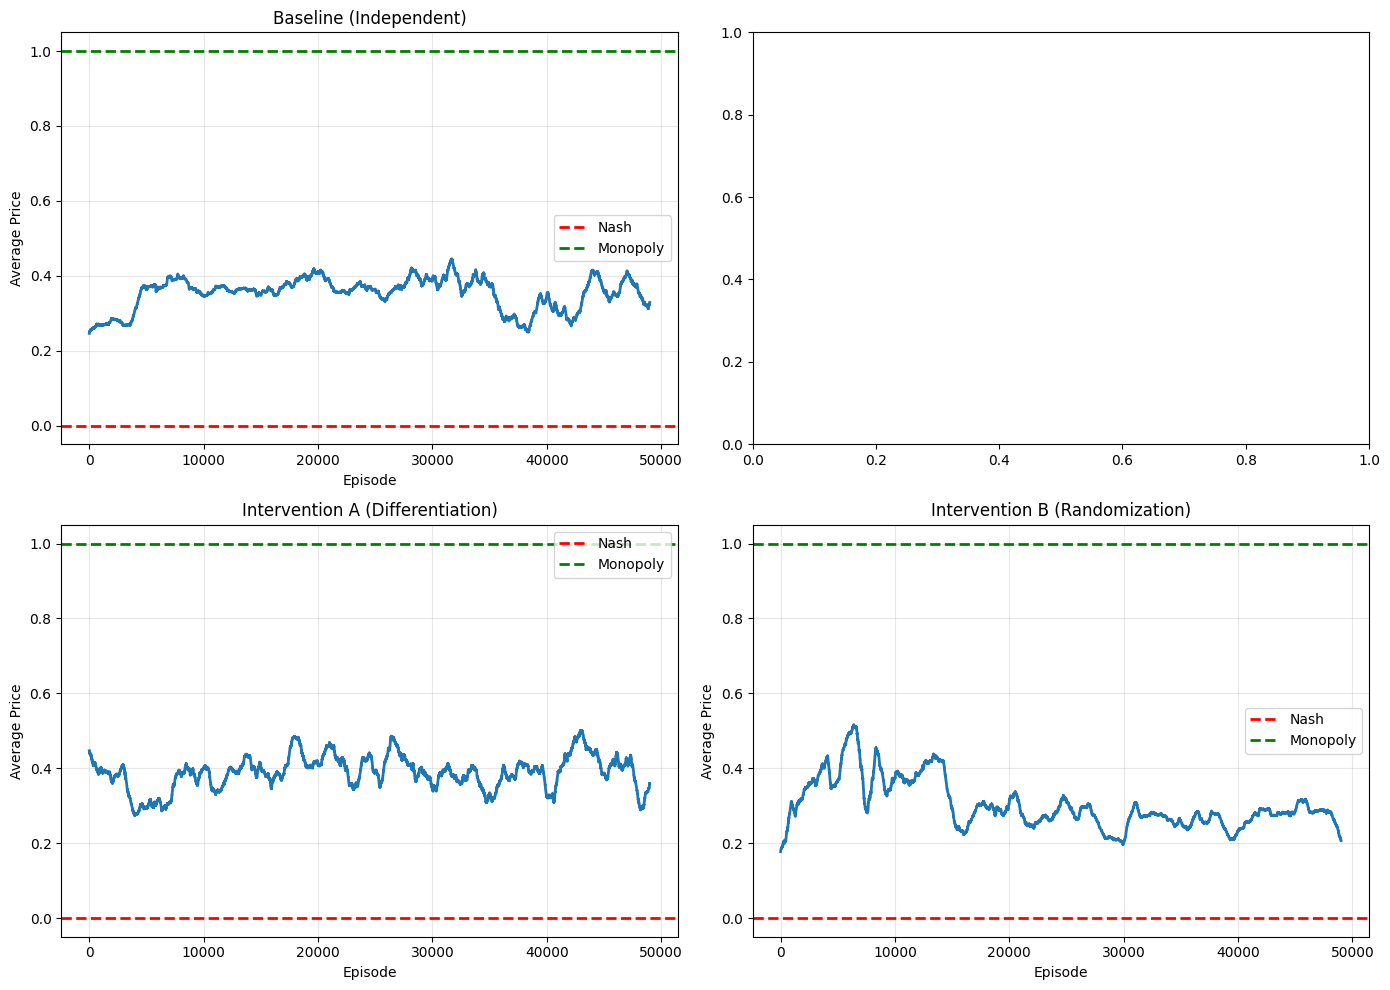

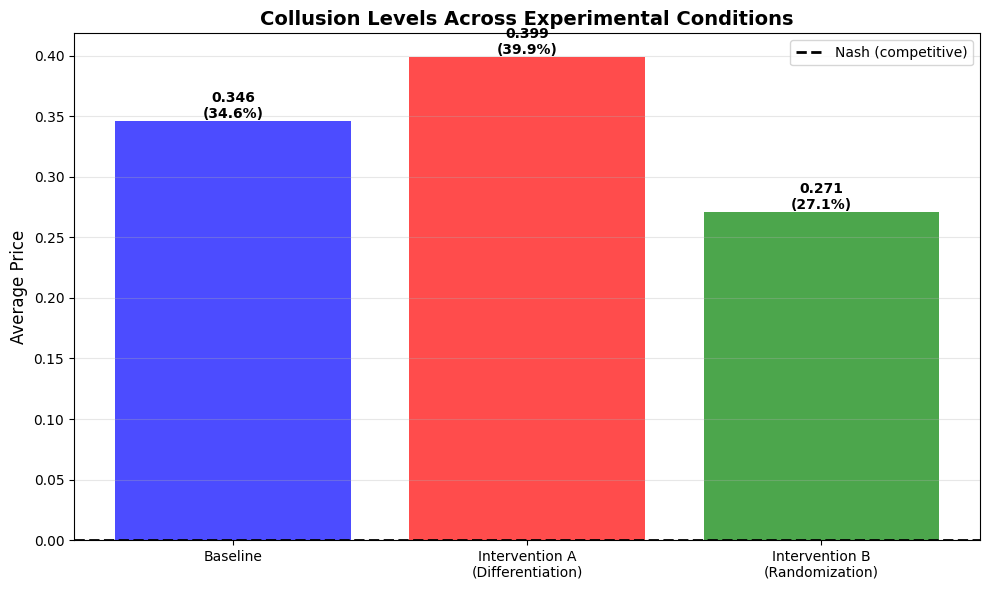

In [ ]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

conditions = [
    (prices_baseline, "Baseline (Independent)", axes[0, 0]),
    (prices_diff, "Intervention A (Differentiation)", axes[1, 0]),
    (prices_random, "Intervention B (Randomization)", axes[1, 1])
]

for price_hist, title, ax in conditions:
    prices_array = np.array(price_hist)

    # Plot rolling average
    window = 1000
    avg_prices = np.mean(prices_array, axis=1)
    rolling_avg = np.convolve(avg_prices, np.ones(window)/window, mode='valid')

    ax.plot(rolling_avg, linewidth=2)
    ax.axhline(y=0.0, color='r', linestyle='--', label='Nash', linewidth=2)
    ax.axhline(y=1.0, color='g', linestyle='--', label='Monopoly', linewidth=2)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Average Price')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Bar chart comparison
fig, ax = plt.subplots(figsize=(10, 6))

condition_names = ['Baseline', 'Intervention A\n(Differentiation)', 'Intervention B\n(Randomization)']
avg_prices_list = [results[k][0] for k in ['Baseline', 'Differentiation', 'Randomization']]

colors = ['blue', 'red', 'green', 'orange']
bars = ax.bar(condition_names, avg_prices_list, color=colors, alpha=0.7)

ax.axhline(y=0.0, color='black', linestyle='--', label='Nash (competitive)', linewidth=2)
ax.set_ylabel('Average Price', fontsize=12)
ax.set_title('Collusion Levels Across Experimental Conditions', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}\n({height*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


Running Q-learning with ±5% price noise...


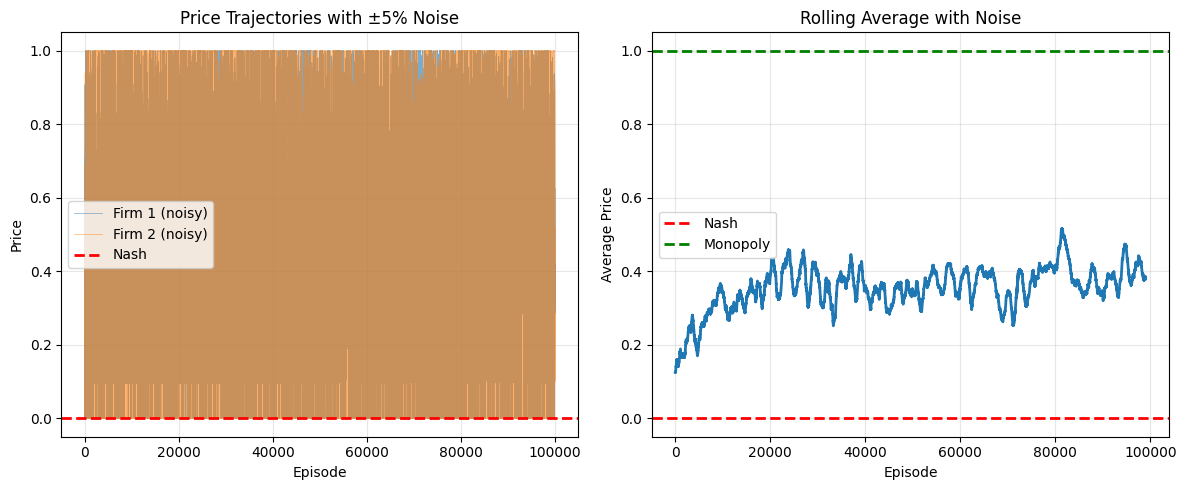


Final average price with noise: £0.391
Collusion level: 39.1%


In [5]:
def q_learning_with_noise(num_episodes=100000, noise_level=0.05):
    """Q-learning with random noise added to executed prices"""

    # Initialize Q-tables
    Q1 = {}
    Q2 = {}
    for my_price in prices:
        for opponent_price in prices:
            Q1[(my_price, opponent_price)] = 0.0
            Q2[(opponent_price, my_price)] = 0.0

    p1 = random.choice(prices)
    p2 = random.choice(prices)
    price_history = []

    for episode in range(num_episodes):
        # FIRM 1's turn
        if random.random() < epsilon:
            new_p1 = random.choice(prices)
        else:
            new_p1 = max(prices, key=lambda p: Q1.get((p, p2), 0.0))

        # ADD NOISE: actual executed price differs by ±5%
        noise1 = random.uniform(-noise_level, noise_level) * new_p1
        executed_p1 = max(0.0, min(1.0, new_p1 + noise1))  # Keep in [0, 1]

        # Calculate profit based on NOISY price
        reward1 = profit(executed_p1, p2, c1=0.0)
        old_q = Q1.get((p1, p2), 0.0)
        max_future_q = max([Q1.get((new_p1, p), 0.0) for p in prices])
        Q1[(p1, p2)] = old_q + alpha * (reward1 + gamma * max_future_q - old_q)
        p1 = new_p1  # Update state with intended price

        # FIRM 2's turn
        if random.random() < epsilon:
            new_p2 = random.choice(prices)
        else:
            new_p2 = max(prices, key=lambda p: Q2.get((p1, p), 0.0))

        # ADD NOISE
        noise2 = random.uniform(-noise_level, noise_level) * new_p2
        executed_p2 = max(0.0, min(1.0, new_p2 + noise2))

        reward2 = profit(executed_p2, p1, c1=0.0)
        old_q2 = Q2.get((p1, p2), 0.0)
        max_future_q2 = max([Q2.get((p1, new_p2), 0.0) for p in prices])
        Q2[(p1, p2)] = old_q2 + alpha * (reward2 + gamma * max_future_q2 - old_q2)
        p2 = new_p2

        # Record ACTUAL executed prices (with noise)
        price_history.append([executed_p1, executed_p2])

    return price_history

# Run simulation with price noise
print("\nRunning Q-learning with ±5% price noise...")
price_history_noise = q_learning_with_noise(num_episodes=100000, noise_level=0.05)

# Plot results
prices_array = np.array(price_history_noise)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(prices_array[:, 0], label='Firm 1 (noisy)', alpha=0.6, linewidth=0.5)
plt.plot(prices_array[:, 1], label='Firm 2 (noisy)', alpha=0.6, linewidth=0.5)
plt.axhline(y=0.0, color='r', linestyle='--', label='Nash', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Price')
plt.title('Price Trajectories with ±5% Noise')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
window = 1000
avg_prices = np.mean(prices_array, axis=1)
rolling_avg = np.convolve(avg_prices, np.ones(window)/window, mode='valid')
plt.plot(rolling_avg, linewidth=2)
plt.axhline(y=0.0, color='r', linestyle='--', label='Nash', linewidth=2)
plt.axhline(y=1.0, color='g', linestyle='--', label='Monopoly', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Average Price')
plt.title('Rolling Average with Noise')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_avg = np.mean(prices_array[-10000:])
print(f"\nFinal average price with noise: £{final_avg:.3f}")
print(f"Collusion level: {(final_avg/1.0)*100:.1f}%")